# NYC Yellow Taxi Growth

#### The objectives of this program:
Using the data set that comes from NYC open data of **NYC Yellow Taxi Service** and **Uber Taxi Service** we would like to **analyze the growth** of the NYC Yellow Taxi Service by using the amount of pickups done daily.

We will be using correlation between taxi and uber in respective borough to observe the **correlation between the growth rate** of both taxi and uber to help understand how competition impacts pickup amounts. We will also use statistics to help **predict the growth** done within the next few days. We will be using **histograms and line charts** to demonstrate the growth.

In [1]:
sc

In [2]:
# imports
import csv
import pandas as pd
import numpy as np
import scipy
import datetime
import matplotlib.dates as mpd
import matplotlib.pyplot as plt
import urllib2
import shapefile
from shapely.geometry import shape, Point

## Taxi vs Uber

In [3]:
taxi_aug14 = sc.textFile('../taxi_aug14_200k.csv'   , use_unicode=False).filter(lambda x: x != "").cache()
uber_aug14 = sc.textFile('../uber-raw-data-aug14.csv', use_unicode=False).cache()
boro_shape = shapefile.Reader('../nyu_2451_34490/nyu_2451_34490.shp')
# list(enumerate(taxi_aug14.first().split(',')))
# list(enumerate(uber_aug14.first().split(',')))

### Borough Estimation

We will be using midpoints of each respective boughs to where the coordinates of the bus data lies.  
We will use the a default distance of 20 miles as the maximum value away from the midterm (that is Staten Island or Manhattan) ends up being around 20 miles.  
If both borough overlap we will use the closest distance. Otherwise, if it doesn't fall in borough distance we will consider it to be outside NYC.

In [4]:
for i in range(5):
    print (i, boro_shape.shapeRecords()[i].record)
lboro = ['Bronx', 'Brooklyn','Manhattan', 'Queens', 'Staten Island']
boro_range = [[],[],[],[],[]]
for i in range(5):
    boro_range[i] = shape(boro_shape.shapeRecords()[i].shape.__geo_interface__)
def getlocation(x):
    import pyproj
    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
    gLoc = Point(proj(float(x[0]) , float(x[1])))
    for i in range(len(boro_range)):
        if(gLoc.within(boro_range[i])):
            return lboro[i]

            

(0, ['36005', 'Bronx', 'Bronx', 'Bronx County'])
(1, ['36047', 'Brooklyn', 'Kings', 'Kings County'])
(2, ['36061', 'Manhattan', 'New York', 'New York County'])
(3, ['36081', 'Queens', 'Queens', 'Queens County'])
(4, ['36085', 'Staten Island', 'Richmond', 'Richmond County'])


In [5]:
p = (-74.00263761, 40.73901691)
getlocation(p)

'Manhattan'

### Data Ingestion for August 2014 Taxi Data

We will clean the data into:  
```((boro, pickup, 1)```  
Then we will group this data as:  
```[boro [(date, count)]]```

In [8]:
def internet_on():
    try:
        urllib2.urlopen('http://216.58.192.142', timeout=1)
        return True
    except urllib2.URLError as err: 
        return False
    
def extractTaxi(partId, records):
    if partId==0:
        records.next()
    reader = csv.reader(records)
    for row in reader:
        (pickup, boro) = (row[1].split(" ")[0], getlocation((row[5],row[6])))
        if boro in ['Bronx', 'Brooklyn','Manhattan', 'Queens', 'Staten Island']:
            yield ((boro, pickup) , 1)
        
if not internet_on():
    print 'internet not on!!!'
    sys.exit()
    
trdd = taxi_aug14.mapPartitionsWithIndex(extractTaxi)\
                .reduceByKey(lambda x, y: x+y)\
                .sortBy(lambda x:(x[0][0], x[0][1]))\
                .map(lambda x: (x[0][0], [(x[0][1], x[1])]))\
                .reduceByKey(lambda x, y: (x+y)) \
                .sortBy(lambda x:(x[0]))
#trdd.take(10)

In [9]:
trdd.take(10)

[('Bronx',
  [('2014-08-05', 28),
   ('2014-08-16', 71),
   ('2014-08-17', 143),
   ('2014-08-18', 1)]),
 ('Brooklyn',
  [('2014-08-05', 540),
   ('2014-08-15', 15),
   ('2014-08-16', 1100),
   ('2014-08-17', 2601),
   ('2014-08-18', 11),
   ('2014-08-19', 4),
   ('2014-08-20', 1)]),
 ('Manhattan',
  [('2014-08-05', 57058),
   ('2014-08-12', 2),
   ('2014-08-13', 11),
   ('2014-08-14', 11),
   ('2014-08-15', 397),
   ('2014-08-16', 47532),
   ('2014-08-17', 73613),
   ('2014-08-18', 431),
   ('2014-08-19', 154),
   ('2014-08-20', 114),
   ('2014-08-21', 4)]),
 ('Queens',
  [('2014-08-05', 3365),
   ('2014-08-12', 1),
   ('2014-08-13', 3),
   ('2014-08-15', 40),
   ('2014-08-16', 2870),
   ('2014-08-17', 5131),
   ('2014-08-18', 47),
   ('2014-08-19', 14),
   ('2014-08-20', 4),
   ('2014-08-21', 2)]),
 ('Staten Island', [('2014-08-16', 1), ('2014-08-17', 1)])]

### Data Ingestion for August 2014 Uber Data

Just like the taxi data, we will format the Uber data just the same.

In [9]:
def extractUber(partId, records):
    if partId==0:
        records.next()
    import csv
    reader = csv.reader(records)
    for row in reader:
        (pickup, boro) = (row[0].split(" ")[0],  getlocation((row[1],row[2])))
        if boro in ['The Bronx', 'Brooklyn', 'Queens', 'Manhattan', 'Staten Island']:
            yield ((boro, pickup) , 1)
        continue
        
if not internet_on():
    print 'internet not on!!!'
    sys.exit()
    
urdd = uber_aug14.mapPartitionsWithIndex(extractUber)\
                .reduceByKey(lambda x, y: x+y)\
                .map(lambda x: ((x[0][0], datetime.datetime.strptime(x[0][1], "%m/%d/%Y").strftime("%Y-%m-%d")), x[1]))\
                .sortBy(lambda x:(x[0][0], x[0][1]))\
                .map(lambda x: (x[0][0], [(x[0][1], x[1])]))\
                .reduceByKey(lambda x, y: (x+y)) \
                .sortBy(lambda x:(x[0]))
#urdd.take(10)

##### This function will get data from either of the dataset

In [100]:
# gets data given a key
def get_data(data, i):
    # returns ALL values
    if i == -1:
        return data.values().map(lambda x: list(zip(*x)[1])).collect()
    # returns ALL dates
    if i == -2:
        return data.values().map(lambda x: zip(*x)[0]).collect()
    # returns all days
    if i == -3:
        return data.values().map(lambda x: zip(*x)[0]) \
            .map(lambda dates : map(lambda date: int(datetime.datetime.strptime(date, "%Y-%m-%d").strftime("%d")), dates)).collect()
    return list(data.values().zipWithIndex().filter(lambda (key,index) : index == i).map(lambda x: zip(*x[0])[1]).collect()[0])
# don't use index 2 in the actual database because it is 'outside_nyc'
lboro = urdd.map(lambda x: x[0]).collect()
nboro = len(trdd.map(lambda x: x[0]).collect())

### Scatter Line Graph for Taxi vs Uber

In [101]:
def make_scatter(tx, ty, ux, uy, title):
    plt.plot(tx, ty,'-o', c ='blue', label = 'taxi')
    plt.plot(ux, uy, '-o', c='red', label = 'uber')
    plt.title(title)
    plt.legend(loc='best')
    plt.xlabel('days')
    plt.ylabel('pickups')
    plt.show()

#### We will first make a scatter to observe the data

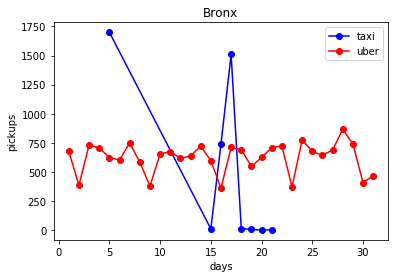

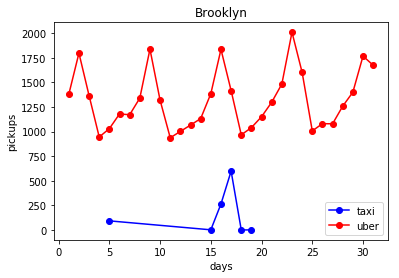

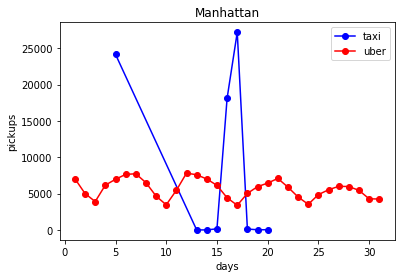

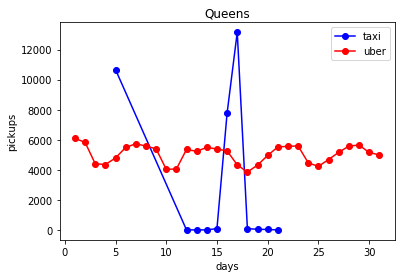

In [102]:
for i in range(nboro):
    make_scatter(get_data(trdd, -3)[i], get_data(trdd, i), get_data(urdd, -3)[i], get_data(urdd, i), lboro[i])

### Cumilative Line Graph for Taxi vs Uber

In [104]:
def get_vb(key):

    # evaluate the histogram
    tvb = list(np.histogram(get_data(trdd, key), bins=30))
    uvb = list(np.histogram(get_data(urdd, key), bins=30))
  
    #evaluate the cumulative
    tvb[0] = np.cumsum(tvb[0])
    uvb[0] = np.cumsum(uvb[0])
    
    return tvb, uvb

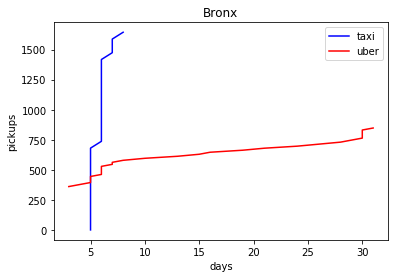

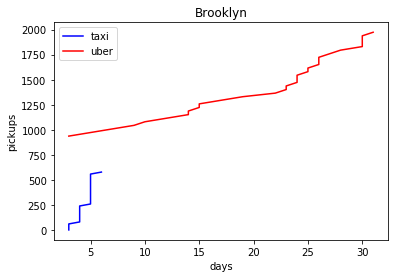

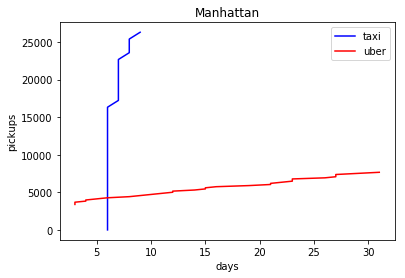

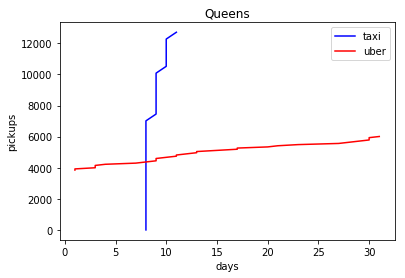

In [105]:
# plot the cumulative functions
def make_accum_graph(tvb, uvb, key):
        plt.plot(tvb[0], tvb[1][:-1], c='blue', label = 'taxi')
        plt.plot(uvb[0], uvb[1][:-1], c='red', label = 'uber')
        plt.title(lboro[key])
        plt.legend(loc='best')
        plt.xlabel('days')
        plt.ylabel('pickups')
        plt.show()
    
for i in range(nboro):
    tvb, uvb = get_vb(i)
    make_accum_graph(tvb, uvb, i)

## Growth Rate Comparison

Then we will make growth rate comparison using histograph of boro based in seperate squares to get a better idea of increase and decrease correlation for both statistics.

In [106]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [107]:
def get_growth(data, key):
    sqlc = SQLContext(sc)

    data = sc.parallelize(data.collect()[key][1])
    df = sqlc.createDataFrame(data, ["date", "value"])
    my_window = Window.partitionBy().orderBy("date")

    df = df.withColumn("prev_value", F.lag(df.value).over(my_window))
    df = df.withColumn("diff", F.when(F.isnull(((df.value - df.prev_value)/df.prev_value)*100), 0)
                                  .otherwise((df.value - df.prev_value)/df.prev_value)*100)
    return df.rdd.map(lambda x: x.date.encode("utf-8")).collect(), df.rdd.map(lambda x: x.diff).collect()

In [111]:
def make_growth_chart(tx, ty, ux, uy, title):
    plt.plot(tx, ty,'-o', c ='blue', label = 'taxi')
    plt.plot(ux, uy, '-o', c='red', label = 'uber')
    plt.axhline(linewidth=3, ls = 'dashed')
    plt.title(title)
    plt.legend(loc='best')
    plt.xlabel('days')
    plt.ylabel('pickups')
    plt.show()

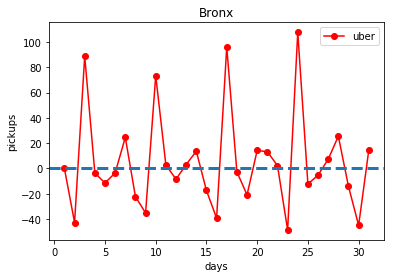

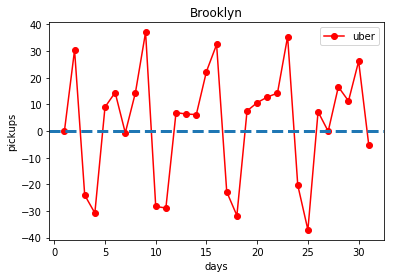

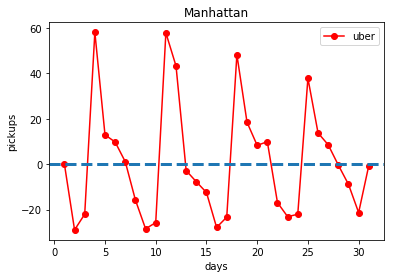

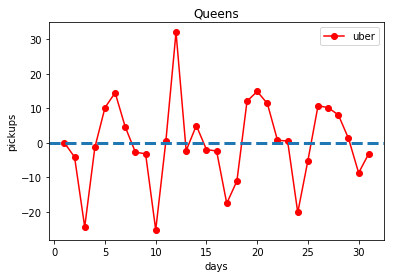

In [112]:
for i in range(nboro):
    make_growth_chart(get_data(trdd, -3)[i], get_growth(trdd, i)[1], get_data(urdd, -3)[i], get_growth(urdd, i)[1], lboro[i])

### Coefficient Correlation

In [113]:
def make_coeff(slope, intercept, x, y, key):
    plt.plot(x, y, 'o', label = 'uber/taxi')
    plt.plot(x, intercept+ slope*x, '-', label = 'correlation' )
    plt.title(lboro[key])
    plt.legend(loc='best')
    plt.xlabel('taxi')
    plt.ylabel('uber')
    plt.show()

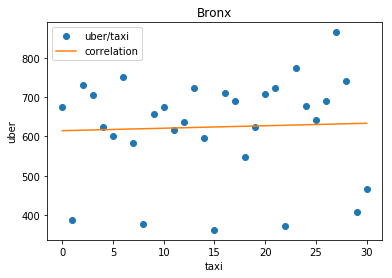

r-value:  0.04385010944169656
p-value:  0.8148091341111183


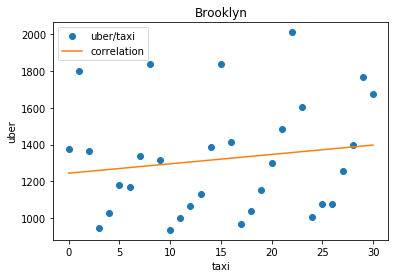

r-value:  0.15255411042034883
p-value:  0.41261967537038646


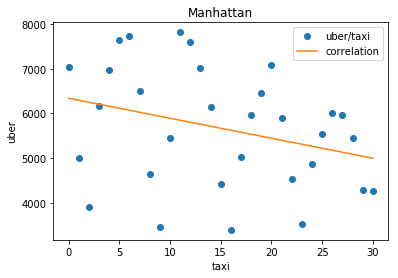

r-value:  -0.30570094425346656
p-value:  0.09443872057298337


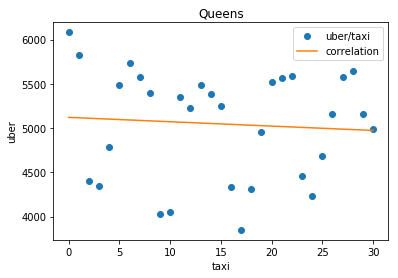

r-value:  -0.07296507610543553
p-value:  0.6964785915734157


In [114]:
from scipy import stats
import numpy as np

l = list(range(len(get_data(urdd, 0))))

for i in range(nboro):
    #x = scipy.array(get_data(trdd, i))
    x = scipy.array(l)
    y = scipy.array(get_data(urdd, i))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    make_coeff(slope, intercept, x, y, i)
    print 'r-value: ', r_value
    print 'p-value: ', p_value

## Prediction

In [115]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split

In [116]:
columns = ['boro', 'days_in_month', 'number_of_pickup']
dic_boro = {'bronx': 0, 'brooklyn': 1, 'manhattan': 2,  'queens': 3, 'staten': 4}

In [ ]:
if not internet_on():
    print 'internet not on!!!'
    sys.exit()

Urdd_table = uber_aug14.mapPartitionsWithIndex(extractUber)\
                .reduceByKey(lambda x, y: x+y)\
                .map(lambda x: ((x[0][0], datetime.datetime.strptime(x[0][1], "%m/%d/%Y").strftime("%Y-%m-%d")), x[1]))\
                .sortBy(lambda x:(x[0][0], x[0][1]))\
                .map(lambda x: (dic_boro[x[0][0]], int(datetime.datetime.strptime(x[0][1], "%Y-%m-%d").strftime("%d")),x[1]))
                               # (x[1]-min_boro[dic_boro[x[0][0]]])/(max_boro[dic_boro[x[0][0]]]- min_boro[dic_boro[x[0][0]]])))

In [ ]:
Urdd_table.take(10)

In [ ]:
df_urdd = Urdd_table.collect()
'''df = pd.DataFrame(Urdd_table.collect(), columns=columns)
df_boro = [[],[],[],[],[],[]]
for i in range(6):
    for j in range(len(df)):
        if df['boro'][j] == i:
            df_boro[i].append(df.loc[j].values)
'''


In [ ]:
df_boro = [[],[],[],[],[],[]]
for i in range(nboro):
    for item in df_urdd:
        if item[0] == i:
            df_boro[i].append(item)
for i in range(6):
    df_boro[i] = pd.DataFrame(df_boro[i], columns=columns)

In [ ]:
X = [[],[],[],[],[],[]]
y =[[],[],[],[],[],[]]
X_train=[[],[],[],[],[],[]]
X_test=[[],[],[],[],[],[]]
y_train=[[],[],[],[],[],[]] 
y_test=[[],[],[],[],[],[]]

for i in range(nboro):
    X[i] = df_boro[i][['boro', 'days_in_month']].values
    y[i] = df_boro[i][['number_of_pickup']].values
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X[i], y[i], test_size=0.4, random_state=1)
    print(X_train[i].shape, X_test[i].shape)

### Cumilative Line Graph for Taxi vs Uber

In [ ]:
linear_r = LinearRegression()
lasso_r = Lasso()
ridge_r = Ridge(alpha=1.0)
elastic_r = ElasticNet(alpha=1, l1_ratio=0.5)

In [ ]:
for i in range(nboro):
    linear_r.fit(X_train[i], y_train[i])
    lasso_r.fit(X_train[i], y_train[i])
    ridge_r.fit(X_train[i], y_train[i])
    elastic_r.fit(X_train[i], y_train[i])
    print(lboro(i), lasso_r.predict(df_boro[i][['boro', 'days_in_month']].values))